In [25]:
def quicksort(arr, compare):
    if len(arr) <= 1:
        return arr
    pivot = arr[len(arr) // 2]
    left = [x for x in arr if compare(x, pivot) == 1]
    middle = [x for x in arr if compare(x, pivot) == 2]
    right = [x for x in arr if compare(x, pivot) == 0]
    return quicksort(left, compare) + middle + quicksort(right, compare)

In [26]:
import random
import numpy as np

In [27]:
import xml.etree.ElementTree as ET
import numpy as np
import re

def extractNumberFromString(string):
    numbers = re.findall(r'\d+', string)
    if numbers:
        return int(numbers[0])  

class task:
    def __init__(self, sources, destinations, dataSize):
        self.sources = sources
        self.destinations = destinations
        self.dataSize = dataSize

class processor:
    def __init__(self, cu, cost):
        self.cu = cu
        self.cost = cost

class workFlow:
    def __init__(self, filePath, deadline):
        self.numberOfTasks = extractNumberFromString(filePath)
        self.tasks = [task([], [], 0)] * self.numberOfTasks
        self.DAG = self.getDAGFromXml(filePath)
        self.deadline = deadline
        degree = self.getDegree()
        self.inDegree = degree[0]
        self.zeroInDegree = degree[1]
       

    def getDAGFromXml(self, filePath):
        tree = ET.parse(filePath)
        root = tree.getroot()
        dx = {}
        namespace = {'dax': 'http://pegasus.isi.edu/schema/DAX'}

        DAG = [[0 for _ in range(self.numberOfTasks)] for _ in range(self.numberOfTasks)]
        jobs = {}
        inData = [[]] * self.numberOfTasks
        outData = [[]] * self.numberOfTasks

        tasks = []
        for i in range(self.numberOfTasks):
            tasks.append(task([], [], 0))
        self.numberOfTasks = 0
        for job in root.findall('.//dax:job', namespace):
            job_id = extractNumberFromString(job.attrib['id'])
            self.numberOfTasks = max(self.numberOfTasks, job_id)
            uses = job.findall('.uses', namespace)
            inputs = []
            outputs = []
            dataSize = 0

            for use in job.findall('.//dax:uses', namespace):
                file = use.attrib['file']
                link = use.attrib['link']
                data = int(use.attrib['size'])
                if data < 0:
                    data = 0 - data
                if file not in dx:
                    dx[file] = [[], -1, data]
                if link == 'input':
                    dx[file][0].append(job_id)
                elif link == 'output':
                    dx[file][1] = job_id

            #inData[job_id] = inputs
            #outData[job_id] = outputs

            #!__________________________________________________
            tasks[job_id].dataSize = float(job.attrib['runtime'])
        self.numberOfTasks += 1
        for dependencies in root.findall('.//dax:child', namespace):
            childId = extractNumberFromString(dependencies.attrib['ref'])
            for parents in dependencies.findall('.//dax:parent', namespace):
                parentId = extractNumberFromString(parents.attrib['ref'])
                tasks[childId].sources.append(parentId)
                tasks[parentId].destinations.append(childId)

        for key in dx:
            for i in range(len(dx[key][0])):
                if dx[key][1] == -1:
                    continue
                DAG[dx[key][1]][dx[key][0][i]] = dx[key][2]
        for i in range(self.numberOfTasks):
            self.tasks[i] = tasks[i]
        return DAG
        
    def getDegree(self):
        inDegree = [0] * self.numberOfTasks
        zeroInDegree = []
        for i in range(0, self.numberOfTasks):
            for j in range(0, self.numberOfTasks):
                if self.DAG[i][j] != 0:
                    inDegree[j] += 1
        for i in range(0, self.numberOfTasks):
            if inDegree[i] == 0:
                zeroInDegree.append(i)
        return (inDegree, zeroInDegree)

In [28]:
network = 20*1024*1024

numberOfProcessors = 9
listProcessors = [
    processor(1, 0.12),
    processor(1.5, 0.195),
    processor(2, 0.28),
    processor(2.5, 0.375),
    processor(3, 0.48),
    processor(3.5, 0.595),
    processor(4, 0.72),
    processor(4.5, 0.855),
    processor(5, 1)
]

class VM:
    def __init__(self, typed, idd):
        self.typed = typed
        self.idd = idd

In [29]:
def isBetter(a, b):
    
    '''if a.fitness == b.fitness:
        return 2
    return a.fitness < b.fitness'''
    
    if a.completionTime == b.completionTime and a.cost == b.cost:
        return 2
    if a.completionTime <= workflow.deadline and b.completionTime <= workflow.deadline:
        return a.cost < b.cost
    if a.completionTime <= workflow.deadline and b.completionTime > workflow.deadline:
        return 1
    if a.completionTime > workflow.deadline and b.completionTime > workflow.deadline:
        return a.completionTime < b.completionTime
    if a.completionTime > workflow.deadline and b.completionTime <= workflow.deadline:
        return 0

In [30]:
import copy

def localSearch(chromosome):
    find = True
    best = Chromosome([], [])
    while find == True:
        #print(chromosome.completionTime, chromosome.cost)
        best.completionTime = 1e9
        best.cost = 1e9
        best.fitness = 1e9
        find = False
        FT = [0] * numberOfProcessors
        FTofTasks = [0] * workflow.numberOfTasks
        process = [0] * len(chromosome.tasks)
        cost = 0
        for i in range(len(chromosome.tasks)):      
            process[chromosome.tasks[i]] = chromosome.processors[i]
        for i in range(len(chromosome.processors)):
            for j in range(numberOfProcessors):
                newChromo = copy.deepcopy(chromosome)
                newChromo.processors[i] = VM(j, 0)
                newChromo.cal_fitness()
                if isBetter(newChromo, chromosome) == 1:
                    find = True
                    if isBetter(newChromo, best):
                        best = copy.deepcopy(newChromo)
        
        #Find best neighbors
        if find == True:
            chromosome = copy.deepcopy(best)
            #print(chromosome.completionTime, chromosome.cost)
            #print("___________________________________________")
    chromosome.isHillClimbing = True
    return chromosome

def localSearchAddVm(chromosome):
    find = True
    Neighbors = []
    #print(chromosome.completionTime, chromosome.cost)
    while find == True:
        find = False
        FTofTasks = [0] * numberOfTasks
        processor = [0] * numberOfTasks
        FT = np.zeros((numberOfProcessors, numberOfTasks))
        for i in range(len(chromosome.tasks)):
            processor[chromosome.tasks[i]] = chromosome.processors[i]
                
        for i in range(len(chromosome.tasks)):
            task = chromosome.tasks[i]
            prc = chromosome.processors[i].typed
            idd = chromosome.processors[i].idd
            DAT_processor = -1
            for j in range(len(workflow.tasks[task].sources)):
                parent = workflow.tasks[task].sources[j]
                DAT_processor = max(DAT_processor, FTofTasks[parent] + ((DAG[parent][task] / network ) if diff(processor[task], processor[parent]) else 0.0))
            if FT[prc][idd] > DAT_processor:
                start = 0
                while (1):
                    if start >= numberOfTasks - 1:
                        break
                    if FT[prc][start] <= DAT_processor:
                        new_chromo = copy.deepcopy(chromosome)
                        new_chromo.processors[i] = VM(prc, start)
                        new_chromo.cal_fitness()
                        if isBetter(new_chromo, chromosome) == 1:
                            Neighbors.append(new_chromo)
                        break
                    start += 1
            #cal FT
            DAT_processor = max(DAT_processor, FT[prc][idd])
            for j in range(len(workflow.tasks[task].destinations)):
                child = workflow.tasks[task].destinations[j]
                FT[prc][idd] = max(FT[prc][idd], FTofTasks[task] + ((DAG[task][child] / network ) if diff(processor[task], processor[child]) else 0.0))
            DAT_prcessor = max(DAT_processor, FT[prc][idd])
            FTofTasks[task] = DAT_processor + computationTime[task][prc]
            FT[prc][idd] = FTofTasks[task]
            
        for i in range(len(Neighbors)):
            if isBetter(Neighbors[i], chromosome) == 1:
                find = True
                chromosome = Neighbors[i]
    chromosome.isHillClimbing = True
    #print(chromosome.completionTime, chromosome.cost)
    #print("___________________________success__________________________________")
    return chromosome 

In [31]:
'''import time

filepath = "D:\WorkFlowTest\dax\CyberShake_50.xml"
workflow = workFlow(filepath, 67.8999)
computationTime = []
for i in range(workflow.numberOfTasks):
    computationTime.append([]) 
for i in range(workflow.numberOfTasks):
    for j in range(numberOfProcessors):
        computationTime[i].append(workflow.tasks[i].dataSize / (listProcessors[j].cu))
numberOfTasks = workflow.numberOfTasks
DAG = workflow.DAG
deadline = workflow.deadline
populationSize = 100
perRandom = 0.5
perHeuristic = 0.5
perElitics = 0.4
perHC = 0.1
penalty = 1
p_c = 0.95
p_m = 0.02
maxGeneration = 400
threshHold = 20
for i in range(30):
    start_time = time.time()
    ga = GA(workflow, populationSize, perRandom, perHeuristic, perElitics, perHC, penalty, p_c, p_m, maxGeneration, threshHold)
    sol = ga.find_solution()
    end_time = time.time()
    print(sol.completionTime, sol.cost, ga.bestGene, end_time - start_time)'''

<>:1: SyntaxWarning: invalid escape sequence '\W'
<>:1: SyntaxWarning: invalid escape sequence '\W'
C:\Users\lminh\AppData\Local\Temp\ipykernel_17640\1140132508.py:1: SyntaxWarning: invalid escape sequence '\W'
  '''import time


'import time\n\nfilepath = "D:\\WorkFlowTest\\dax\\CyberShake_50.xml"\nworkflow = workFlow(filepath, 67.8999)\ncomputationTime = []\nfor i in range(workflow.numberOfTasks):\n    computationTime.append([]) \nfor i in range(workflow.numberOfTasks):\n    for j in range(numberOfProcessors):\n        computationTime[i].append(workflow.tasks[i].dataSize / (listProcessors[j].cu))\nnumberOfTasks = workflow.numberOfTasks\nDAG = workflow.DAG\ndeadline = workflow.deadline\npopulationSize = 100\nperRandom = 0.5\nperHeuristic = 0.5\nperElitics = 0.4\nperHC = 0.1\npenalty = 1\np_c = 0.95\np_m = 0.02\nmaxGeneration = 400\nthreshHold = 20\nfor i in range(30):\n    start_time = time.time()\n    ga = GA(workflow, populationSize, perRandom, perHeuristic, perElitics, perHC, penalty, p_c, p_m, maxGeneration, threshHold)\n    sol = ga.find_solution()\n    end_time = time.time()\n    print(sol.completionTime, sol.cost, ga.bestGene, end_time - start_time)'

In [33]:
import math

def diff(a, b):
    return not ((a.typed == b.typed) and (a.idd == b.idd))
    #return not (a.typed == b.typed)

class Chromosome:
    def __init__(self, processors, tasks):
        self.processors = processors
        self.tasks = tasks
        self.completionTime = 0
        self.fitness = 0
        self.cost = 0.0
        self.isHillClimbing = False
        #self.cal_fitness()

    @staticmethod
    def crossover(chromosome1, chromosome2, crossover_rate):
    
        numTasks = len(chromosome1.tasks)
        Child1 = Chromosome([VM(0, 0)] * numTasks, [-1] * numTasks)
        Child2 = Chromosome([VM(0, 0)] * numTasks, [-1] * numTasks)

        if random.random() > crossover_rate:
            return None

        #get position to crossover
        pos = random.randint(1, numTasks)
        dxC1 = [False] * (numTasks + 1)
        dxC2 = [False] * (numTasks + 1)
        #take left part from parents
        for i in range(pos):
            Child1.tasks[i] = chromosome1.tasks[i]
            Child1.processors[i] = chromosome1.processors[i]
            dxC1[chromosome1.tasks[i]] = True
            Child2.tasks[i] = chromosome2.tasks[i]
            Child2.processors[i] = chromosome2.processors[i]
            dxC2[chromosome2.tasks[i]] = True

        #take right part from parents
        ps = pos
        for i in range(numTasks):
            if dxC1[chromosome2.tasks[i]] == False:
                Child1.processors[ps] = chromosome2.processors[i]
                Child1.tasks[ps] = chromosome2.tasks[i]
                dxC1[chromosome2.tasks[i]] = True
                ps += 1
        ps = pos
        for i in range(numTasks):
            if dxC2[chromosome1.tasks[i]] == False:
                Child2.processors[ps] = chromosome1.processors[i]
                Child2.tasks[ps] = chromosome1.tasks[i]
                dxC2[chromosome1.tasks[i]] = True
                ps += 1
        
        return Child1, Child2
    
    def mutate(self, mutation_rate):
        mutated_processors = self.processors[:]  # Create a copy of distributing
        
        # Choose a random position to mutate
        mutate_position = random.randint(0, len(mutated_processors) - 1)
        
        # Mutate the value at the chosen position based on the mutation rate
        if random.random() < mutation_rate:
            mutated_processors[mutate_position].typed = random.randint(0, numberOfProcessors - 1)
            mutated_processors[mutate_position].idd = 0
        
        # Return a new Chromosome object with the mutated distributing and the original scheduling_parts
        return Chromosome(mutated_processors, self.tasks)

    def cal_fitness(self):
        FTofTasks = [0] * numberOfTasks
        processor = [0] * numberOfTasks
        FT = np.zeros((numberOfProcessors, numberOfTasks))
        endLeaseTime = np.zeros((numberOfProcessors, numberOfTasks))
        startLeaseTime = array = np.full((numberOfProcessors, numberOfTasks), 1e9)
        dx = {}

        completionTime = 0.0
        cost = 0.0
        for i in range(len(self.tasks)):
            processor[self.tasks[i]] = self.processors[i]
            
        for i in range(len(self.tasks)):
            task = self.tasks[i]
            prc = self.processors[i].typed
            idd = self.processors[i].idd
            dx[(prc, idd)] = True
            DAT_processor = FT[prc][idd]
            for j in range(len(workflow.tasks[task].sources)):
                parent = workflow.tasks[task].sources[j]
                DAT_processor = max(DAT_processor, FTofTasks[parent] + ((DAG[parent][task] / network ) if diff(processor[task], processor[parent]) else 0.0))
            FTofTasks[task] = DAT_processor + computationTime[task][prc]
            FT[prc][idd] = FTofTasks[task]
            completionTime = max(completionTime, FTofTasks[task])
    
            endLeaseTime[prc][idd] = max(endLeaseTime[prc][idd], FTofTasks[task])
            for j in range(len(workflow.tasks[task].destinations)):
                child = workflow.tasks[task].destinations[j]
                endLeaseTime[prc][idd] = max(endLeaseTime[prc][idd], FTofTasks[task] + ((DAG[task][child] / network ) if diff(processor[task], processor[child]) else 0.0))
                FT[prc][idd] = max(FT[prc][idd], FTofTasks[task] + ((DAG[task][child] / network ) if diff(processor[task], processor[child]) else 0.0))
                
            startLeaseTime[prc][idd] = min(startLeaseTime[prc][idd], DAT_processor)
            for j in range(len(workflow.tasks[task].sources)):
                parent = workflow.tasks[task].sources[j]
                startLeaseTime[prc][idd] = min(startLeaseTime[prc][idd], DAT_processor - ((DAG[parent][task] / network ) if diff(processor[task], processor[parent]) else 0.0))

        for i in range(len(self.processors)):
            dd = self.processors[i].idd
            kieu = self.processors[i].typed
            if (kieu, dd) in dx:
                dx.pop((kieu, dd))
                cost += (math.ceil((endLeaseTime[kieu][dd] - startLeaseTime[kieu][dd]) / 3600)) * listProcessors[kieu].cost
        
        self.cost = cost
        self.completionTime = completionTime
        self.fitness = cost
        if completionTime > workflow.deadline:
            self.fitness += penalty * (completionTime - workflow.deadline)

In [11]:
'''filepath = "C:/Users/lminh/OneDrive/Desktop/test_8.xml"
workflow = workFlow(filepath, 1000)
computationTime = []
for i in range(workflow.numberOfTasks):
    computationTime.append([]) 
for i in range(workflow.numberOfTasks):
    for j in range(numberOfProcessors):
        computationTime[i].append(workflow.tasks[i].dataSize / (listProcessors[j].cu))
numberOfTasks = workflow.numberOfTasks
DAG = workflow.DAG
deadline = workflow.deadline
c = Chromosome([VM(8, 0), VM(7, 0), VM(8, 0), VM(8, 0), VM(8, 0)], (0, 2, 1, 3, 4))
c.cal_fitness()
print(c.completionTime, c.cost)'''

'filepath = "C:/Users/lminh/OneDrive/Desktop/test_8.xml"\nworkflow = workFlow(filepath, 1000)\ncomputationTime = []\nfor i in range(workflow.numberOfTasks):\n    computationTime.append([]) \nfor i in range(workflow.numberOfTasks):\n    for j in range(numberOfProcessors):\n        computationTime[i].append(workflow.tasks[i].dataSize / (listProcessors[j].cu))\nnumberOfTasks = workflow.numberOfTasks\nDAG = workflow.DAG\ndeadline = workflow.deadline\nc = Chromosome([VM(8, 0), VM(7, 0), VM(8, 0), VM(8, 0), VM(8, 0)], (0, 2, 1, 3, 4))\nc.cal_fitness()\nprint(c.completionTime, c.cost)'

In [34]:
def tournamentSelection(tournament):
    winner = Chromosome([0] * workflow.numberOfTasks, [0] * workflow.numberOfProcessors)
    for i in range(len(tournament)):
        if isBetter(tournament[i], winner) == 1:
            winner = tournament[i]
    return winner

In [35]:
def selectBest(population, size, percentage):
    size = int(size * percentage)
    sortarr = quicksort(population, isBetter)
    newGen = []
    for i in range(size):
        newGen.append(sortarr[i])
    return newGen

In [36]:
def chooseProcessor(typed, task):
    if typed == 0:
        return random.randint(0, numberOfProcessors - 1)
    else:
        total_time = sum(computationTime[task])
        if total_time == 0:
            total_time = 0.0000001
        positions = []
        for i, time in enumerate(computationTime[task]):
            # Tính xác suất của mỗi vị trí dựa trên thời gian tính toán
            probability = 1 - (time / total_time)
            positions.extend([i] * int(probability * numberOfTasks))  # Nhân với 100 để tăng độ chính xác
        # Chọn ngẫu nhiên một vị trí từ danh sách
        random_position = random.choice(positions)
        return random_position

def createRandomChromosome(inDegree, zeroInDegree, typed):
    inDegree_copy = inDegree[:]
    zeroInDegree_copy = zeroInDegree[:]
    chromosome = Chromosome([0] * numberOfTasks, [0] * numberOfTasks)
    i = 0
    while(len(zeroInDegree_copy) > 0):
        index_task = random.randint(0, len(zeroInDegree_copy) - 1)
        task = zeroInDegree_copy[index_task]
        processor = chooseProcessor(typed, task)
        chromosome.tasks[i] = task
        chromosome.processors[i] = VM(processor, 0)
        zeroInDegree_copy.pop(index_task)
        for j in range(len(workflow.tasks[task].destinations)):
            adj = workflow.tasks[task].destinations[j]
            inDegree_copy[adj] -= 1
            if inDegree_copy[adj] == 0:
                zeroInDegree_copy.append(adj)
        i += 1

    #multi thread
    chromosome.cal_fitness()
    return chromosome

In [37]:
def generateRandomPopulation(size, percentage, inDegree, zeroInDegree):
    randomPopulation = []
            
    #generate Ramdom Select population
    size = int(size * percentage)
    #percentageOfRandom = 0.50
    #percentageOfRandomBasedOnComputeTime = 0.25
    randomType = 0
    #basedOnComputeTime = 1
    #sizeR = int(percentageOfRandom * size)
    #sizeB = int(percentageOfRandomBasedOnComputeTime * size)
    for i in range(size):
        randomPopulation.append(createRandomChromosome(inDegree, zeroInDegree, randomType))
    #for i in range(sizeB):
        #randomPopulation.append(createRandomChromosome(inDegree, zeroInDegree, basedOnComputeTime))
    return randomPopulation

In [38]:
def createHeuristicChromosome(inDegree, zeroInDegree):
    inDegree_copy = inDegree[:]
    zeroInDegree_copy = zeroInDegree[:]
    chromosome = Chromosome([VM(0, 0)] * numberOfTasks, [0] * numberOfTasks)
    FT = [0] * numberOfProcessors
    process = [VM(0, 0)] * numberOfTasks
    FTofTasks = [0] * numberOfTasks
    i = 0
    while(len(zeroInDegree_copy) > 0):
        index_task = random.randint(0, len(zeroInDegree_copy) - 1)
        task = zeroInDegree_copy[index_task]
        #choose processor
        minFT = min(FT)
        FT = [x - minFT for x in FT]
        FT_thu = {}
        for j in range(len(FT)):
            if FT[j] == 0:
                FT_thu[j] = 0
                for k in range(len(workflow.tasks[task].sources)):
                    parentTask = workflow.tasks[task].sources[k]
                    FT_thu[j] = max(FT_thu[j], max(FT[j], FTofTasks[parentTask] + (DAG[parentTask][task] if process[parentTask] != j else 0)))
                FT_thu[j] += computationTime[task][j]
        total_value = sum(FT_thu.values())
        # Tính tỷ lệ xác suất cho mỗi phần tử
        probabilities = [value / total_value for value in FT_thu.values()]
        # Chọn ngẫu nhiên một phần tử dựa trên xác suất
        chosen = random.choices(list(FT_thu.keys()), weights=probabilities, k=1)[0]
        
        chromosome.tasks[i] = task
        chromosome.processors[i] = VM(chosen, 0)
        process[task] = VM(chosen, 0)
        FT[chosen] = FT_thu[chosen]
        FTofTasks[task] = FT_thu[chosen]

        zeroInDegree_copy.pop(index_task)
        for j in range(len(workflow.tasks[task].destinations)):
            adj = workflow.tasks[task].destinations[j]
            inDegree_copy[adj] -= 1
            if inDegree_copy[adj] == 0:
                zeroInDegree_copy.append(adj)
        i += 1

    #multi thread
    chromosome.cal_fitness()
    return chromosome

In [39]:
def generateHeuristicPopulation(size, percentage, inDegree, zeroInDegree):
    heuristicPopulation = []
    size = int(percentage * size)
    for i in range(size):
        chro = createHeuristicChromosome(inDegree, zeroInDegree)
        #print(chro.processors, chro.tasks, "cc")
        heuristicPopulation.append(chro)
    return heuristicPopulation

In [40]:
class GA:
    def __init__(self, workFlow, populationSize, perRandom, perHeuristic, perElitics, perHC, penalty, p_c, p_m, maxGeneration, threshHold):
        self.populationSize = populationSize
        self.worfFlow = workFlow
        self.penalty = penalty
        self.p_c = p_c
        self.p_m = p_m
        self.maxGeneration = maxGeneration
        self.threshHold = threshHold
        self.perRandom = perRandom
        self.perHeuristic = perHeuristic
        self.perElitics = perElitics
        self.perHC = perHC
        self.bestGene = 0

        self.population = generateRandomPopulation(populationSize, perRandom, workFlow.inDegree, workFlow.zeroInDegree) + generateHeuristicPopulation(populationSize, perHeuristic, workFlow.inDegree, workFlow.zeroInDegree) 
    
    
    def find_solution(self):
        best = Chromosome([VM(0, 0)] * numberOfTasks, [0] * numberOfTasks)
        best.completionTime = 1e8
        best.cost = 1e8
        best.fitness = 1e8
        notImprove = 0
        for gene in range(self.maxGeneration):
            #print(gene)
            '''print(len(self.population))
            for j in range(len(self.population)):
                #print(self.population[j].completionTime, self.population[j].cost)
                for k in range(len(self.population[j].processors)):
                    print(self.population[j].processors[k].typed, end = " ")
                print()
            print("_______________________________________")'''
            nextGen = selectBest(self.population, self.populationSize, self.perElitics) #get parent population

            '''print(len(nextGen))
            for j in range(len(nextGen)):
                print(nextGen[j].completionTime, nextGen[j].cost)
            print("______________nextTo_________________________")'''
            
            
            while (len(nextGen) < self.populationSize):
                parents = random.sample(self.population, 2)
                child = Chromosome.crossover(parents[0], parents[1], p_c)
                if child == None:
                    continue
                child0 = child[0].mutate(p_m)
                child1 = child[1].mutate(p_m)

                #multi thread
                child0.cal_fitness()
                child1.cal_fitness()
                nextGen.append(child0)
                nextGen.append(child1)

            nextGen = quicksort(nextGen, isBetter)
            total_elements = len(nextGen)
            num_elements_to_select = int(self.perHC * total_elements)
            # Tạo danh sách các chỉ mục có thể được chọn, với xác suất cao hơn ở đầu
            indices_with_bias = list(range(num_elements_to_select))
            ss = int(perHC * populationSize)
            for _ in range(ss):
                # Lấy ngẫu nhiên chỉ mục từ danh sách với xác suất cao hơn ở đầu
                selected_index = random.choices(indices_with_bias, weights=[2 ** i for i in range(num_elements_to_select)], k=1)[0]
                # Lấy phần tử tương ứng với chỉ mục đã chọn
                if nextGen[selected_index].isHillClimbing:
                    continue
                else:
                    nextGen[selected_index].isHillClimbing = True
                    #print(nextGen[selected_index].completionTime, nextGen[selected_index].cost)
                    nextGen[selected_index] = localSearch(nextGen[selected_index])
                    #if ():
                    nextGen[selected_index] = localSearchAddVm(nextGen[selected_index])
                    #print(nextGen[selected_index].completionTime, nextGen[selected_index].cost)
                    #print("_______________________________________________________________")
            nextGen = quicksort(nextGen, isBetter)
            nn = 0
            averageViolation = 0
            for i in range(len(nextGen)):
                if nextGen[i].completionTime > workflow.deadline:
                    nn += 1
                    averageViolation += nextGen[i].completionTime - workflow.deadline
            if nn == 0:
                averageViolation = 1
            
            if isBetter(nextGen[0], best) == 1:
                self.bestGene = gene
                notImprove = 0
                best = nextGen[0]
                penalty = nextGen[0].completionTime / averageViolation
            else:
                notImprove += 1
                penalty = nextGen[len(nextGen) - 1].completionTime / averageViolation
                if notImprove >= self.threshHold:
                    return best
            self.population = nextGen
        return best

In [41]:
filepath = "D:\WorkFlowTest\dax\LIGO_30.xml"
workflow = workFlow(filepath, 298.7861700000001)

computationTime = []
for i in range(workflow.numberOfTasks):
    computationTime.append([]) 
for i in range(workflow.numberOfTasks):
    for j in range(numberOfProcessors):
        computationTime[i].append(workflow.tasks[i].dataSize / (listProcessors[j].cu))

populationSize = 300
perRandom = 0.5
perHeuristic = 0.5
perElitics = 0.4
perHC = 0.1
penalty = 1
p_c = 0.95
p_m = 0.02
maxGeneration = 100
threshHold = 40
'''for i in range(30):
    ga = GA(workflow, populationSize, perRandom, perHeuristic, perElitics, perHC, penalty, p_c, p_m, maxGeneration, threshHold)
    sol = ga.find_solution()
    print(sol.completionTime, sol.cost, ga.bestGene)'''

<>:1: SyntaxWarning: invalid escape sequence '\W'
<>:1: SyntaxWarning: invalid escape sequence '\W'
C:\Users\lminh\AppData\Local\Temp\ipykernel_17640\2305718162.py:1: SyntaxWarning: invalid escape sequence '\W'
  filepath = "D:\WorkFlowTest\dax\LIGO_30.xml"


'for i in range(30):\n    ga = GA(workflow, populationSize, perRandom, perHeuristic, perElitics, perHC, penalty, p_c, p_m, maxGeneration, threshHold)\n    sol = ga.find_solution()\n    print(sol.completionTime, sol.cost, ga.bestGene)'

In [42]:
filepath = "D:\WorkFlowTest\dax\CyberShake_30.xml"
workflow = workFlow(filepath, 62)

computationTime = []
for i in range(workflow.numberOfTasks):
    computationTime.append([]) 
for i in range(workflow.numberOfTasks):
    for j in range(numberOfProcessors):
        computationTime[i].append(workflow.tasks[i].dataSize / (listProcessors[j].cu))

<>:1: SyntaxWarning: invalid escape sequence '\W'
<>:1: SyntaxWarning: invalid escape sequence '\W'
C:\Users\lminh\AppData\Local\Temp\ipykernel_17640\577090386.py:1: SyntaxWarning: invalid escape sequence '\W'
  filepath = "D:\WorkFlowTest\dax\CyberShake_30.xml"


In [193]:
!pip install openpyxl

^C



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import time
import numpy as np
sizesWorkflow = ["30", "50", "100"]
nameWorkflow = ["/CyberShake", "/Epigenomics", "/Inspiral", "/LIGO", "/Montage"]
sourceDAX = "D:/WorkFlowTest/dax"
cheapScheduleCost = np.array([
    [0.12, 0.12, 0.12],
    [0.6, 1.44, 13.56],
    [0.24, 0.48, 0.72],
    [0.24, 0.48, 0.72],
    [0.12, 0.12, 0.12]
])
fastScheduleMakespan = np.array([[58.367999999999995, 60.58, 65.20400000000001],
    [1124.21, 1553.6480000000001, 5975.6500000000015],
    [267.03600000000006, 282.16, 266.552],
    [267.03600000000006, 282.16, 266.552],
    [11.302, 14.152000000000001, 17.144000000000002]])
cheapScheduleMakespan = np.array([[760.5299999999999, 1524.5600000000004, 3215.7499999999995],
    [17720.15, 41401.780000000006, 403400.19999999995],
    [6617.0700000000015, 11761.949999999999, 21023.960000000003],
    [6617.0700000000015, 11761.949999999999, 21023.960000000003],
    [227.74999999999997, 508.64000000000016, 1079.3400000000004]])

result = np.random.randint(0, 100, size=(100, 100, 2))
runtime = np.zeros((10, 10, 10))
populationSize = 100
perRandom = 0.5
perHeuristic = 0.5
perElitics = 0.4
perHC = 0.1
penalty = 1
p_c = 0.95
p_m = 0.02
maxGeneration = 400
threshHold = 20
lmao = 0
for factor in np.arange(0.005, 0.055, 0.005):
    lmao += 1
    factor = round(factor, 3)
    for j in range(len(nameWorkflow)):
        filename = sourceDAX  + nameWorkflow[j]
        numrun = 0.0
        success = 0.0
        cost = 0.0
        print("______________start__________________")
        for k in range(len(sizesWorkflow)):
            filename1 = filename + "_" + sizesWorkflow[k] + ".xml"
            workflow = workFlow(filename1, 0)
            computationTime = []
            for i in range(workflow.numberOfTasks):
                    computationTime.append([]) 
            for i in range(workflow.numberOfTasks):
                for jj in range(numberOfProcessors):
                    computationTime[i].append(workflow.tasks[i].dataSize / (listProcessors[jj].cu))
            numberOfTasks = workflow.numberOfTasks
            DAG = workflow.DAG
            deadline = fastScheduleMakespan[j][k] + (cheapScheduleMakespan[j][k] - fastScheduleMakespan[j][k]) * factor
            workflow.deadline = deadline
            print(filename1, factor)
            print(deadline)

            aa = 0
            timee = 0
            for test in range(11):
                numrun += 1
                start_time = time.time()
                ga = GA(workflow, populationSize, perRandom, perHeuristic, perElitics, perHC, penalty, p_c, p_m, maxGeneration, threshHold)
                sol = ga.find_solution()
                end_time = time.time()
                timee += end_time - start_time
                print(sol.completionTime, sol.cost)
                if sol.completionTime <= workflow.deadline:
                    success += 1
                aa +=  sol.cost / cheapScheduleCost[j][k]
            cost += aa / 10
            timee /= 10
            runtime[j][k][lmao] = timee
        print(nameWorkflow[j], factor, success / numrun, cost)
        result[j][lmao] = (success / numrun, cost) 
    print(sucess / numrun, cost)
    print("_____________end_____________________")

______________start__________________
D:/WorkFlowTest/dax/CyberShake_30.xml 0.005
61.878809999999994


NameError: name 'Chromosome' is not defined

In [ ]:
print(result)

In [ ]:
print(runtime)

In [ ]:
ketqua = [[(0.0, 0.0) for _ in range(20)] for _ in range(20)]
lmao = -1
for j in range(len(nameWorkflow)):
    if j != 0:
        continue
    filename = sourceDAX  + nameWorkflow[j]
    for factor in np.arange(0.005, 0.055, 0.005):
        lmao += 1
        factor = round(factor, 3)
        filename1 = filename + "_" + sizesWorkflow[0] + ".xml"
        workflow = workFlow(filename1, 0)
        computationTime = []
        for i in range(workflow.numberOfTasks):
                computationTime.append([]) 
        for i in range(workflow.numberOfTasks):
            for jj in range(numberOfProcessors):
                computationTime[i].append(workflow.tasks[i].dataSize / (listProcessors[jj].cu))
        numberOfTasks = workflow.numberOfTasks
        DAG = workflow.DAG
        deadline = fastScheduleMakespan[j][k] + (cheapScheduleMakespan[j][k] - fastScheduleMakespan[j][k]) * factor
        workflow.deadline = deadline
        print(filename1, factor, j, lmao)
        print(workflow.deadline)
        success = 0.0
        numrun = 0.0
        cost = 0.0
        for test in range(30):
            numrun += 1
            start_time = time.time()
            ga = GA(workflow, populationSize, perRandom, perHeuristic, perElitics, perHC, penalty, p_c, p_m, maxGeneration, threshHold)
            sol = ga.find_solution()
            end_time = time.time()
            print(sol.completionTime, sol.cost, end_time - start_time, ga.bestGene)
            if sol.completionTime <= workflow.deadline:
                success += 1
            cost +=  sol.cost / cheapScheduleCost[j][k]
        ketqua[j][lmao] = (success / numrun, cost / numrun)
        print(success / numrun, cost / numrun)
        print("___________________________success____________________________________")

D:/WorkFlowTest/dax/CyberShake_30.xml 0.005 0 0
61.878809999999994
61.83766165924072 4.98 63.85072660446167 47
61.11588388146294 4.699999999999999 54.348397731781006 34
61.842598019705875 5.14 44.806787729263306 21
61.79880902502271 4.305 54.41504645347595 25
61.25851725006104 4.22 44.92327523231506 21
61.84985353999667 4.05 49.20227241516113 6
61.839020206663335 4.62 39.77396607398987 14
61.219109060287465 4.939999999999999 56.87238121032715 56
61.09980747298588 4.125 51.99132180213928 46
61.77366165924072 4.145 47.02010464668274 32
60.86366165924072 5.499999999999999 41.400254249572754 19
61.85866306380619 4.5 37.552698850631714 0
61.7788060684204 5.159999999999999 50.516369342803955 24
60.269661659240725 4.499999999999999 54.172714948654175 38
61.166517250061034 4.244999999999999 52.28170037269592 36
61.64152020666334 5.0249999999999995 53.474233627319336 40
61.7968060684204 5.0249999999999995 45.72935342788696 8


In [197]:
print(ketqua)

[[(0.3, 36.64583333333333), (0.9, 34.23888888888889), (0.9666666666666667, 31.995833333333326), (1.0, 31.088888888888885), (1.0, 29.23611111111111), (0.9666666666666667, 30.312499999999996), (1.0, 29.575), (1.0, 29.809722222222216), (1.0, 29.26944444444444), (1.0, 28.98055555555555), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)], [(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)], [(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)], [(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (

In [202]:
#test GA -populationSize parameters

filename = sourceDAX  + nameWorkflow[0]
filename1 = filename + "_" + sizesWorkflow[0] + ".xml"
workflow = workFlow(filename1, 0)
computationTime = []
for i in range(workflow.numberOfTasks):
        computationTime.append([]) 
for i in range(workflow.numberOfTasks):
    for jj in range(numberOfProcessors):
        computationTime[i].append(workflow.tasks[i].dataSize / (listProcessors[jj].cu))
numberOfTasks = workflow.numberOfTasks
DAG = workflow.DAG
deadline = fastScheduleMakespan[0][0] + (cheapScheduleMakespan[0][0] - fastScheduleMakespan[0][0]) * 0.005
workflow.deadline = deadline
print(deadline, filename1)
bestPopulationSize = 0
bestss = 1e9
bestcost = 1e9
print("____________________________TEST POPULATION SIZE_____________________________________")
for ps in range(100, 1001, 100):
    populationSize = ps
    perRandom = 0.5
    perHeuristic = 0.5
    perElitics = 0.4
    perHC = 0.1
    penalty = 1
    p_c = 0.95
    p_m = 0.02
    maxGeneration = 400
    threshHold = 20
    sc = 0.0
    cost = 0.0
    for i in range(30):
        ga = GA(workflow, populationSize, perRandom, perHeuristic, perElitics, perHC, penalty, p_c, p_m, maxGeneration, threshHold)
        sol = ga.find_solution()
        if (sol.completionTime <= deadline):
            sc += 1
        cost += sol.cost / cheapScheduleCost[0][0]
    if (bestcost > cost / 30):
        bestPopulationSize = ps
        bestcost = cost / 30
        bestss = sc / 10
    print("populationSize: ", ps, sc / 30, cost / 30)
print("_______bestPopulationSize_________: ", bestPopulationSize)
print("____________________________TEST MAXGENERATION_____________________________________" )
bestss = 1e9
bestcost = 1e9
bestmg = 0
for mg in range(100, 1001, 100):
    populationSize = bestPopulationSize
    perRandom = 0.5
    perHeuristic = 0.5
    perElitics = 0.4
    perHC = 0.1
    penalty = 1
    p_c = 0.95
    p_m = 0.02
    maxGeneration = mg
    threshHold = 20
    sc = 0.0
    cost = 0.0
    for i in range(30):
        ga = GA(workflow, populationSize, perRandom, perHeuristic, perElitics, perHC, penalty, p_c, p_m, maxGeneration, threshHold)
        sol = ga.find_solution()
        if (sol.completionTime <= deadline):
            sc += 1
        cost += sol.cost / cheapScheduleCost[0][0]
    if (bestcost > cost / 30):
        bestmg = mg
        bestcost = cost / 30
        bestss = sc / 10
    print("maxGeneration: ", mg, sc / 30, cost / 30)
print("_______bestMaxGeneration_________: ", bestmg)
print("____________________________TEST THRESHOLD_____________________________________" )
bestss = 1e9
bestcost = 1e9
bestth = 0
for th in range(10, 100, 10):
    populationSize = bestPopulationSize
    perRandom = 0.5
    perHeuristic = 0.5
    perElitics = 0.4
    perHC = 0.1
    penalty = 1
    p_c = 0.95
    p_m = 0.02
    maxGeneration = bestmg
    threshHold = th
    sc = 0.0
    cost = 0.0
    for i in range(30):
        ga = GA(workflow, populationSize, perRandom, perHeuristic, perElitics, perHC, penalty, p_c, p_m, maxGeneration, threshHold)
        sol = ga.find_solution()
        if (sol.completionTime <= deadline):
            sc += 1
        cost += sol.cost / cheapScheduleCost[0][0]
    if (bestcost > cost / 30):
        bestth = th
        bestcost = cost / 30
        bestss = sc / 10
    print("threshhold: ", th, sc / 30, cost / 30)
print("_______bestThreshold_________: ", bestth)

61.878809999999994 D:/WorkFlowTest/dax/CyberShake_30.xml
____________________________TEST POPULATION SIZE_____________________________________
populationSize:  100 0.9 42.025
populationSize:  200 0.9666666666666667 41.98055555555555
populationSize:  300 1.0 39.46805555555555
populationSize:  400 1.0 39.44444444444444
populationSize:  500 1.0 37.17361111111111
populationSize:  600 1.0 38.159722222222214
populationSize:  700 1.0 37.8986111111111
populationSize:  800 1.0 38.075
populationSize:  900 1.0 38.96527777777778
populationSize:  1000 1.0 38.176388888888894
_______bestPopulationSize_________:  500
____________________________TEST MAXGENERATION_____________________________________


KeyboardInterrupt: 

In [204]:
!pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/17/91/febbb6c1063ae05a62fdbe038c2917b348b1b35f0482cee4738e6870a44a/matplotlib-3.9.0-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/78/38/a046bb0ebce6f530175d434e7364149e338ffe1069ee286ed8ba7f6481ee/contourpy-1.2.1-cp312-cp312-win_amd64.whl.metadata
  Using cached contourpy-1.2.1-cp312-cp312-win_amd64.whl.metadata (5.8 kB)
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/56/85/0a77382e3dd8528d7f13ee97415c82b36c4879023f226e2b98d012fce077/fonttools-4.51.0-cp312-cp312-win_amd64.whl.metadata
  

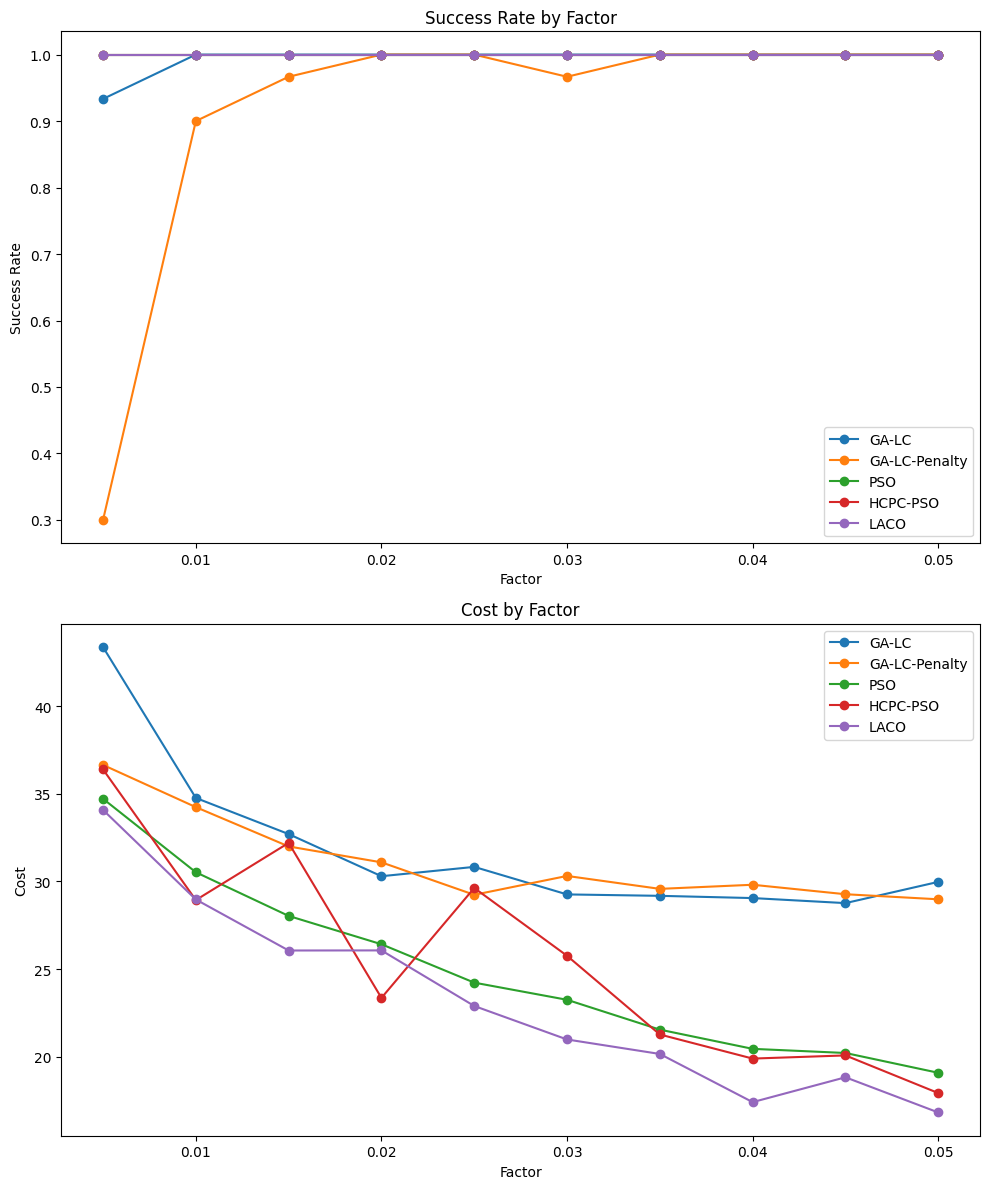

In [205]:
import matplotlib.pyplot as plt

# Data input
algorithms = {
    'GA-LC': [
        (0.005, 0.9333333333333333, 43.3694444),
        (0.01, 1.0, 34.76249999),
        (0.015, 1.0, 32.70138888),
        (0.02, 1.0, 30.29722222),
        (0.025, 1.0, 30.8291667),
        (0.03, 1.0, 29.2583333),
        (0.035, 1.0, 29.177775),
        (0.04, 1.0, 29.05),
        (0.045, 1.0, 28.7625),
        (0.05, 1.0, 29.973)
    ],
    'GA-LC-Penalty': [
        (0.005, 0.3, 36.64583333333333),
        (0.01, 0.9, 34.23888888888889),
        (0.015, 0.9666666666666667, 31.995833333333326),
        (0.02, 1.0, 31.088888888888885),
        (0.025, 1.0, 29.23611111111111),
        (0.03, 0.9666666666666667, 30.312499999999996),
        (0.035, 1.0, 29.575),
        (0.04, 1.0, 29.809722222222216),
        (0.045, 1.0, 29.26944444444444),
        (0.05, 1.0, 28.98055555555555)
    ],
    'PSO': [
        (0.005, 1.0, 34.715277777777764),
        (0.01, 1.0, 30.523611111111116),
        (0.015, 1.0, 28.03194444444444),
        (0.02, 1.0, 26.415277777777778),
        (0.025, 1.0, 24.224999999999998),
        (0.03, 1.0, 23.245833333333334),
        (0.035, 1.0, 21.54305555555555),
        (0.04, 1.0, 20.447222222222226),
        (0.045, 1.0, 20.211111111111112),
        (0.05, 1.0, 19.081944444444442)
    ],
    'HCPC-PSO': [
        (0.005, 1.0, 36.391666666666666),
        (0.01, 1.0, 28.93611111111111),
        (0.015, 1.0, 32.197222222222216),
        (0.02, 1.0, 23.35416666666667),
        (0.025, 1.0, 29.627777777777776),
        (0.03, 1.0, 25.75694444444444),
        (0.035, 1.0, 21.26666666666667),
        (0.04, 1.0, 19.891666666666666),
        (0.045, 1.0, 20.072222222222226),
        (0.05, 1.0, 17.925000000000004)
    ],
    'LACO': [
        (0.005, 1.0, 34.077777777777776),
        (0.01, 1.0, 28.96944444444444),
        (0.015, 1.0, 26.058333333333326),
        (0.02, 1.0, 26.063888888888883),
        (0.025, 1.0, 22.89305555555556),
        (0.03, 1.0, 20.981944444444444),
        (0.035, 1.0, 20.15555555555556),
        (0.04, 1.0, 17.406944444444445),
        (0.045, 1.0, 18.825000000000003),
        (0.05, 1.0, 16.818055555555556)
    ]
}

# Plotting setup
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Success rate plot
for algo, data in algorithms.items():
    factors = [x[0] for x in data]
    success_rates = [x[1] for x in data]
    axes[0].plot(factors, success_rates, label=algo, marker='o')
axes[0].set_xlabel('Factor')
axes[0].set_ylabel('Success Rate')
axes[0].set_title('Success Rate by Factor')
axes[0].legend()

# Cost plot
for algo, data in algorithms.items():
    factors = [x[0] for x in data]
    costs = [x[2] for x in data]
    axes[1].plot(factors, costs, label=algo, marker='o')
axes[1].set_xlabel('Factor')
axes[1].set_ylabel('Cost')
axes[1].set_title('Cost by Factor')
axes[1].legend()

plt.tight_layout()
plt.show()